# **DQN Extensions**

### This project aims in implementation of DQN extension such as DDQN, Duelling DDQN and Prioritized Experience Replay(PER) Buffer for SpaceInvaders Environment from MinAtar package.

# **Package Installation**

In [ ]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

# **Imports**

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Iterable

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools
import math

# **Model  Network**

In [2]:
class Duelling_DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(Duelling_DQN, self).__init__()

        self.register_buffer("action_num", torch.tensor(num_actions, dtype=torch.int))

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)

        self.linear = nn.Linear(32*6*6, 512)

        self.value = nn.Linear(512, 1)
        self.advantage = nn.Linear(512, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.linear(x))

        value = self.value(x)
        advantage = self.advantage(x)

        q_value = value + advantage - torch.sum(advantage)/self.action_num

        return q_value

# **Action Selection Policy**

In [3]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)

        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

# **Decay Methods for Hyperparameters - Epsilon, Alpha, Beta**

In [4]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    # TODO: your code
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

In [5]:
def exponential_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    if current_timestep >= duration:
        return eps_end
    decay_rate = -math.log(eps_end / eps_start) / duration
    epsilon = eps_end + (eps_start - eps_end) * math.exp(-decay_rate * current_timestep)
    return epsilon

In [6]:
def restarting_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int, restarts: int, exploit: int) -> float:
    """
    Exponential decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """
    interval = round(duration/restarts)
    if current_timestep >= duration:
        return eps_end
    ratio = min(1.0, ((current_timestep % interval) +  exploit) / (interval))
    lin_ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio)*(1-lin_ratio) + eps_end

# **Prioritized Experience Replay Buffer (PER)**

In [7]:
class PrioritizedReplayBuffer:
    def __init__(self, max_size: int, obs_size):
        self.max_size = max_size
        self.obs = torch.empty(size = (max_size, obs_size[0], obs_size[1], obs_size[2]))
        self.act_rew_term = torch.zeros(size = (max_size,3))
        self.next_obs = torch.empty(size = (max_size, obs_size[0], obs_size[1], obs_size[2]))
        self.priorities = torch.zeros(max_size)
        self.probabilities = torch.zeros(max_size)
        self.probabilities[0] = 1
        self.position = 0
        self.max = 0

    def __len__(self) -> int:
        return len(self.data)

    def get_probabilities(self, alpha):
        scaled_priorities = torch.pow(self.priorities, alpha)
        if torch.sum(scaled_priorities) == 0:
            return torch.tensor([1])
        else:
           return scaled_priorities / torch.sum(scaled_priorities)

    def set_priorities(self, indices, errors, offset=0.05):
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

    def get_importance(self, probabilities, beta):
        N_length = max(self.max, self.position)
        importance_weight = (1/N_length) * (1/probabilities)
        scaled_importance_weight = torch.pow(importance_weight, beta)
        max_weight = torch.max(scaled_importance_weight) #To normalize
        return (scaled_importance_weight / max_weight)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        self.obs[self.position] = obs
        self.act_rew_term[self.position,:] = torch.tensor([action, reward, terminated])
        self.next_obs[self.position] = next_obs
        self.priorities[self.position] = max(self.priorities[0:self.position], default=1)
        if (self.position + 1) % self.max_size == 0:
            self.max = self.max_size
        self.position = (self.position + 1) % self.max_size

    def update_probabilities(self, alpha):
        self.probabilities = self.get_probabilities(alpha)

    def sample(self, batch_size: int, alpha=1.0, beta=1.0) -> torch.Tensor:
        indexer = range(0,max(self.max, self.position))
        sample_indices = torch.tensor(random.choices(indexer, k=batch_size, weights=self.probabilities[0:max(self.max, self.position)].tolist()))
        selected_obs = self.obs[sample_indices]
        selected_nextobs = self.next_obs[sample_indices]
        act_rew_term = self.act_rew_term[sample_indices]
        importance = self.get_importance(self.probabilities[sample_indices], beta)
        return selected_obs, act_rew_term[:,0], act_rew_term[:,1], selected_nextobs, act_rew_term[:,2], sample_indices, importance

# **Update Q Network**

In [8]:
def update_ddqn_per(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        importance_weights: torch.Tensor,
    ):

    optimizer.zero_grad()

    with torch.no_grad():
        next_q_from_qmodel = q(next_obs)
        next_q_state_from_target = q_target(next_obs)

        max_val = torch.max(next_q_from_qmodel, 1)[1]
        q_val_target = next_q_state_from_target.gather(1, max_val.unsqueeze(1))
        td_target = rew.unsqueeze(1) + gamma * q_val_target * (1 - tm.float().unsqueeze(1))

    q_val = q(obs).gather(1, act.type(torch.int64).unsqueeze(1))

    mseloss = F.mse_loss(q_val, td_target)
    importance_weights_mean = importance_weights.mean()
    weighted_loss = mseloss * importance_weights_mean

    weighted_loss.backward()
    optimizer.step()

    error_batch =  torch.sub(q_val, td_target)
    error_batch = error_batch.detach()

    return error_batch


# **Agent Creation**

In [9]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class Duelling_DDQN_PER_Agent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            exploit_phase = 400,
            restarts = 4,
            update_freq=100,
            maxlen=100_000,
            alpha=1.0,
            beta=1.0,
            alpha_beta_start = 1.0,
            alpha_beta_end = 0.1,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.alpha = alpha
        self.beta = beta
        self.alpha_beta_start = alpha_beta_start
        self.alpha_beta_end = alpha_beta_end
        self.exploit_phase = exploit_phase
        self.restarts = restarts

        self.buffer = PrioritizedReplayBuffer(maxlen, env.observation_space.shape)
        self.q = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

        for params in self.q_target.parameters():
            params.requires_grad = False


    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0

        epsilon = self.eps_start
        alpha = self.alpha
        beta = self.beta

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 10 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f} Alpha: {alpha:.3f} Beta: {beta:.3f}')

            obs, _ = self.env.reset()

            for episode_time in itertools.count():

                epsilon = restarting_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration, self.restarts, self.exploit_phase)
                alpha = exponential_decay(self.alpha_beta_start, self.alpha_beta_end, current_timestep, self.schedule_duration)
                beta = exponential_decay(self.alpha_beta_start, self.alpha_beta_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(int(terminated))
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch, sample_indices, importance = self.buffer.sample(self.batch_size, alpha, beta)

                # Update the Q network
                batch_errors = update_ddqn_per(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch,
                    importance
                )

                # Set prirority of experience based on errors returned from Update step
                self.buffer.set_priorities(sample_indices, batch_errors)
                self.buffer.update_probabilities(alpha)

                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

# **Environment Creation**

In [10]:
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)



# **Setting Hyperparameters**

In [13]:
LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 30000
EXPLOIT_PHASE = 400
RESTARTS = 4
NUM_EPISODES = 100
DISCOUNT_FACTOR = 0.99
ALPHA = 1.0
BETA = 1.0
ALPHA_BETA_START = 1.0
ALPHA_BETA_END = 0.05

# **Train Agent**

In [14]:
# Train Duelling DDQN With Priority Experience Replay (PER) Buffer
agent_duelling_ddqn_per = Duelling_DDQN_PER_Agent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    exploit_phase = EXPLOIT_PHASE,
    restarts = RESTARTS,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    alpha = ALPHA,
    beta = BETA,
    alpha_beta_start = ALPHA_BETA_START,
    alpha_beta_end = ALPHA_BETA_END,

)
stats_duelling_ddqn_per = agent_duelling_ddqn_per.train(NUM_EPISODES)

Episode 10 of 100  Time Step: 456  Epsilon: 0.443 Alpha: 0.958 Beta: 0.958
Episode 20 of 100  Time Step: 1128  Epsilon: 0.395 Alpha: 0.899 Beta: 0.899
Episode 30 of 100  Time Step: 1652  Epsilon: 0.359 Alpha: 0.856 Beta: 0.856
Episode 40 of 100  Time Step: 2432  Epsilon: 0.307 Alpha: 0.795 Beta: 0.795
Episode 50 of 100  Time Step: 3005  Epsilon: 0.271 Alpha: 0.754 Beta: 0.754
Episode 60 of 100  Time Step: 3544  Epsilon: 0.238 Alpha: 0.717 Beta: 0.717
Episode 70 of 100  Time Step: 4362  Epsilon: 0.190 Alpha: 0.665 Beta: 0.665
Episode 80 of 100  Time Step: 5248  Epsilon: 0.142 Alpha: 0.613 Beta: 0.613
Episode 90 of 100  Time Step: 6275  Epsilon: 0.089 Alpha: 0.558 Beta: 0.558
Episode 100 of 100  Time Step: 8176  Epsilon: 0.330 Alpha: 0.470 Beta: 0.470


# **Results**

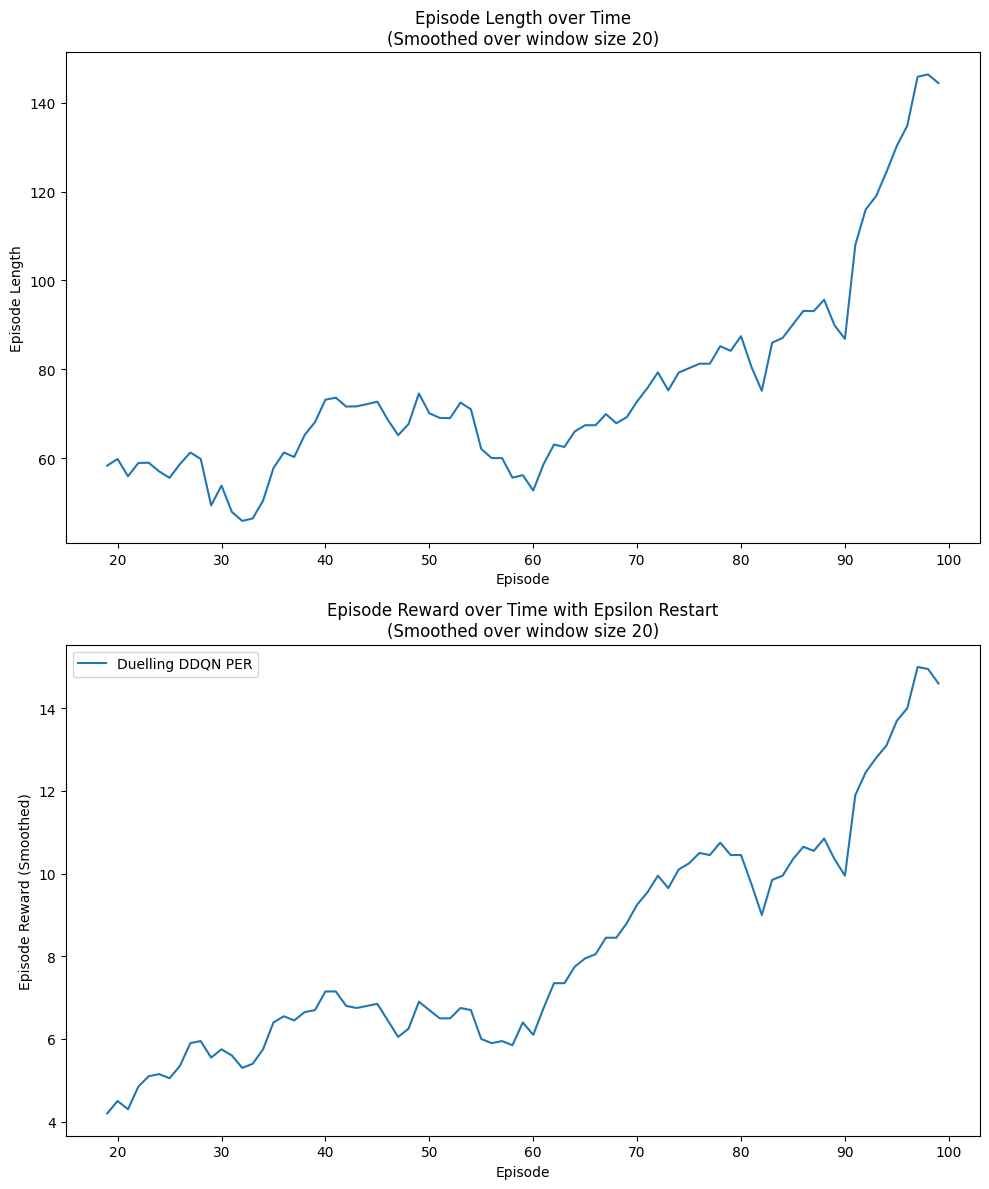

In [15]:
smoothing_window=20 #2
fig, axes = plt.subplots(2, 1, figsize=(10, 12), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
lengths_smoothed_duelling_ddqn_per = pd.Series(stats_duelling_ddqn_per.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()

ax.plot(lengths_smoothed_duelling_ddqn_per, label="Duelling DDQN PER")

ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title(f"Episode Length over Time\n(Smoothed over window size {smoothing_window})")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed_duelling_ddqn_per = pd.Series(stats_duelling_ddqn_per.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()

ax.plot(rewards_smoothed_duelling_ddqn_per, label="Duelling DDQN PER")

ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time with Epsilon Restart\n(Smoothed over window size {smoothing_window})")
plt.legend()
plt.show()

c:\Users\U755531\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
c:\Users\U755531\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:276: UserWarning: WARN: RGB-array rendering should return a numpy array with dtype uint8, got float64
  logger.warn(


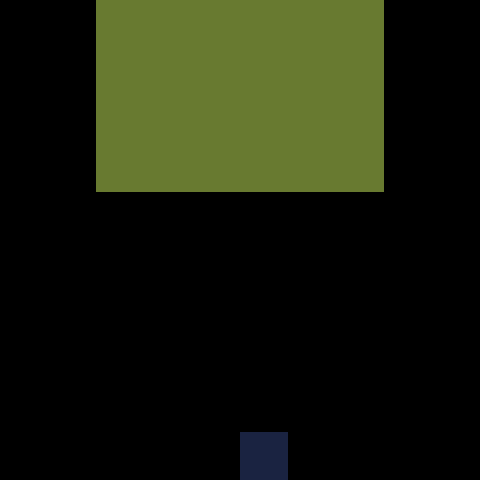

In [16]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent_duelling_ddqn_per.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")